# Natural language processing: spam detection

In [24]:
# Handle imports up-front
import regex as re
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from utils import cross_val

## 1. Data loading

### 1.1. Load the data

In [25]:
# Read csv file into dataframe
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')

# Drop duplicates if any
data_df.drop_duplicates(inplace=True)
data_df.reset_index(inplace=True, drop=True)

### 1.2. Inspect the data

In [26]:
print(data_df.columns)


Index(['url', 'is_spam'], dtype='object')


In [27]:
# Your code her# Display the first few rows
print(data_df.head())

# Get basic information about the dataset
print(data_df.info())

# Check for missing values
print(data_df.isnull().sum())

# Summary statistics
print(data_df.describe(include='all'))

# Check the distribution of target labels (if applicable)
print(data_df['is_spam'].value_counts())


                                                 url  is_spam
0  https://briefingday.us8.list-manage.com/unsubs...     True
1                             https://www.hvper.com/     True
2                 https://briefingday.com/m/v4n3i4f3     True
3   https://briefingday.com/n/20200618/m#commentform    False
4                        https://briefingday.com/fan     True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369 entries, 0 to 2368
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2369 non-null   object
 1   is_spam  2369 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 20.9+ KB
None
url        0
is_spam    0
dtype: int64
                                                      url is_spam
count                                                2369    2369
unique                                               2369       2
top     https://briefingday.us8.list-manage.com/unsubs...   False
freq            

### 1.3. Train-test split

In [28]:
# Separate features from labels
labels=data_df['is_spam']
features=data_df.drop('is_spam', axis=1)

# Encode the labels
encoded_labels = labels.apply(lambda x: 1 if x else 0).astype(int)

# Split the data into training and testing features and labels
training_features, testing_features, encoded_training_labels, encoded_testing_labels=train_test_split(
    features,
    encoded_labels,
    test_size=0.25,
    random_state=315
)

## 2. EDA

### 2.1. Text preprocessing

In [29]:
print(training_features['url'].head(10))


311     https://www.nytimes.com/2020/06/19/us/into-the...
2317    https://digg.cmail20.com/t/t-u-ptuurik-vkjjhbl...
1953                     http://snarkmarket.com/2010/4890
1872          https://www.youtube.com/watch?v=8RYdItBIuOU
1752    https://www.wired.com/story/amazon-shakes-self...
2069    https://www.nbcnewyork.com/news/local/future-o...
2116    https://www.reuters.com/article/us-usa-stocks/...
217     https://www.reuters.com/article/us-people-mala...
769     https://www.theverge.com/2020/6/24/21302080/co...
2275    https://www1.nyc.gov/office-of-the-mayor/news/...
Name: url, dtype: object


In [30]:
def clean_url(url):
    # Remove protocols and subdomains
    url = re.sub(r'https?://(www\.)?', '', url)
    # Remove non-alphanumeric characters
    url = re.sub(r'[^a-zA-Z0-9]', ' ', url)
    # Convert to lowercase
    url = url.lower()
    # Optional: Remove common uninformative words
    common_words = ['com', 'org', 'gov', 'html']
    url = ' '.join([word for word in url.split() if word not in common_words])
    return url


In [31]:
training_features['cleaned_url'] = training_features['url'].apply(clean_url)
print(training_features[['url', 'cleaned_url']].head(10))


                                                    url  \
311   https://www.nytimes.com/2020/06/19/us/into-the...   
2317  https://digg.cmail20.com/t/t-u-ptuurik-vkjjhbl...   
1953                   http://snarkmarket.com/2010/4890   
1872        https://www.youtube.com/watch?v=8RYdItBIuOU   
1752  https://www.wired.com/story/amazon-shakes-self...   
2069  https://www.nbcnewyork.com/news/local/future-o...   
2116  https://www.reuters.com/article/us-usa-stocks/...   
217   https://www.reuters.com/article/us-people-mala...   
769   https://www.theverge.com/2020/6/24/21302080/co...   
2275  https://www1.nyc.gov/office-of-the-mayor/news/...   

                                            cleaned_url  
311     nytimes 2020 06 19 us into the wild bus removed  
2317             digg cmail20 t t u ptuurik vkjjhbly ih  
1953                              snarkmarket 2010 4890  
1872                        youtube watch v 8ryditbiuou  
1752  wired story amazon shakes self driving ride ha...  
20

In [32]:
from collections import Counter
all_words = ' '.join(training_features['cleaned_url']).split()
word_counts = Counter(all_words).most_common(20)
print(word_counts)


[('2020', 592), ('06', 407), ('the', 267), ('news', 194), ('us', 167), ('to', 156), ('coronavirus', 141), ('of', 127), ('article', 100), ('in', 88), ('story', 82), ('and', 81), ('a', 78), ('utm', 78), ('on', 72), ('nytimes', 71), ('6', 71), ('youtube', 70), ('morningbrew', 69), ('daily', 67)]


In [33]:
from nltk.corpus import stopwords
import nltk

# Download stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_url(url):
    url = re.sub(r'https?://(www\.)?', '', url)
    url = re.sub(r'[^a-zA-Z0-9]', ' ', url)
    url = url.lower()
    common_words = ['com', 'org', 'gov', 'html', 'utm']
    url = ' '.join([word for word in url.split() if word not in common_words and word not in stop_words])
    return url

training_features['cleaned_url'] = training_features['url'].apply(clean_url)


[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
training_features['cleaned_url'] = training_features['url'].apply(clean_url)

# Reanalyze word frequencies
all_words = ' '.join(training_features['cleaned_url']).split()
word_counts = Counter(all_words).most_common(20)
print(word_counts)


[('2020', 592), ('06', 407), ('news', 194), ('us', 167), ('coronavirus', 141), ('article', 100), ('story', 82), ('nytimes', 71), ('6', 71), ('youtube', 70), ('morningbrew', 69), ('daily', 67), ('trump', 67), ('watch', 66), ('19', 64), ('stories', 64), ('new', 63), ('v', 61), ('numlock', 60), ('29', 58)]


In [35]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_url(url):
    # Remove protocols and subdomains
    url = re.sub(r'https?://(www\.)?', '', url)
    # Remove non-alphanumeric characters
    url = re.sub(r'[^a-zA-Z0-9]', ' ', url)
    # Convert to lowercase
    url = url.lower()
    # Remove common uninformative words and stopwords
    common_words = ['com', 'org', 'gov', 'html', 'utm', 'www']
    url = ' '.join([word for word in url.split() if word not in common_words and word not in stop_words])
    # Remove isolated numeric terms (already done earlier)
    return url


In [36]:
training_features['cleaned_url'] = training_features['url'].apply(clean_url)


In [37]:
all_words = ' '.join(training_features['cleaned_url']).split()
word_counts = Counter(all_words).most_common(20)
print(word_counts)


[('2020', 592), ('06', 407), ('news', 194), ('us', 167), ('coronavirus', 141), ('article', 100), ('story', 82), ('nytimes', 71), ('6', 71), ('youtube', 70), ('morningbrew', 69), ('daily', 67), ('trump', 67), ('watch', 66), ('19', 64), ('stories', 64), ('new', 63), ('v', 61), ('numlock', 60), ('29', 58)]


In [38]:
def clean_url(url):
    # Remove protocols and subdomains
    url = re.sub(r'https?://(www\.)?', '', url)
    # Remove non-alphanumeric characters
    url = re.sub(r'[^a-zA-Z0-9]', ' ', url)
    # Convert to lowercase
    url = url.lower()
    # Remove common uninformative words and stopwords
    common_words = ['com', 'org', 'gov', 'html', 'utm', 'www']
    url = ' '.join([word for word in url.split() if word not in common_words and word not in stop_words])
    # Remove isolated numeric terms and terms containing only digits
    url = ' '.join([word for word in url.split() if not word.isdigit()])
    return url


In [39]:
training_features['cleaned_url'] = training_features['url'].apply(clean_url)


In [40]:
all_words = ' '.join(training_features['cleaned_url']).split()
word_counts = Counter(all_words).most_common(20)
print(word_counts)


[('news', 194), ('us', 167), ('coronavirus', 141), ('article', 100), ('story', 82), ('nytimes', 71), ('youtube', 70), ('morningbrew', 69), ('daily', 67), ('trump', 67), ('watch', 66), ('stories', 64), ('new', 63), ('v', 61), ('numlock', 60), ('world', 55), ('reuters', 54), ('en', 50), ('covid', 49), ('substack', 49)]


In [41]:
spam_urls = training_features[encoded_training_labels == 1]['cleaned_url']
non_spam_urls = training_features[encoded_training_labels == 0]['cleaned_url']

spam_words = Counter(' '.join(spam_urls).split()).most_common(20)
non_spam_words = Counter(' '.join(non_spam_urls).split()).most_common(20)

print("Top Words in Spam URLs:", spam_words)
print("Top Words in Non-Spam URLs:", non_spam_words)


Top Words in Spam URLs: [('numlock', 60), ('substack', 40), ('p', 36), ('sunday', 31), ('list', 16), ('manage', 16), ('morningbrew', 11), ('austinkleon', 11), ('unsubscribe', 10), ('subscribe', 10), ('creativemornings', 8), ('us2', 8), ('docs', 7), ('google', 7), ('forms', 7), ('viewform', 7), ('pages', 7), ('annfriedman', 6), ('skimm', 6), ('daily', 6)]
Top Words in Non-Spam URLs: [('news', 194), ('us', 163), ('coronavirus', 137), ('article', 100), ('story', 82), ('nytimes', 70), ('trump', 67), ('youtube', 66), ('watch', 65), ('stories', 62), ('new', 62), ('v', 61), ('daily', 61), ('morningbrew', 58), ('world', 55), ('reuters', 54), ('covid', 48), ('en', 47), ('index', 47), ('briefingday', 46)]


### 2.2. Lematization

In [42]:
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_url(url):
    # Remove protocols and subdomains
    url = re.sub(r'https?://(www\.)?', '', url)
    # Remove non-alphanumeric characters
    url = re.sub(r'[^a-zA-Z0-9]', ' ', url)
    # Convert to lowercase
    url = url.lower()
    # Tokenize and lemmatize
    words = url.split()
    common_words = ['com', 'org', 'gov', 'html', 'utm', 'www']
    stop_words = set(stopwords.words('english'))
    words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in common_words and word not in stop_words and not word.isdigit()
    ]
    return ' '.join(words)


In [43]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_url(url):
    # Remove protocols and subdomains
    url = re.sub(r'https?://(www\.)?', '', url)
    # Remove non-alphanumeric characters
    url = re.sub(r'[^a-zA-Z0-9]', ' ', url)
    # Convert to lowercase
    url = url.lower()
    # Tokenize and lemmatize
    words = url.split()
    common_words = ['com', 'org', 'gov', 'html', 'utm', 'www']
    words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in common_words and word not in stop_words and not word.isdigit()
    ]
    return ' '.join(words)


[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vscode/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.3. Vectorization

In [45]:
baseline_model = SVC(random_state=315)

# Cross-validate the model using TF-IDF features
from sklearn.model_selection import cross_val_score

scores = cross_val_score(baseline_model, X_train, encoded_training_labels, cv=5)

# Save results
results = {'Baseline': scores}
print("Cross-validation scores:", scores)


Cross-validation scores: [0.93539326 0.93239437 0.94084507 0.92676056 0.93802817]


In [47]:
training_features['cleaned_url'] = training_features['url'].apply(clean_url)
testing_features['cleaned_url'] = testing_features['url'].apply(clean_url)


In [48]:
print(training_features.columns)
print(testing_features.columns)


Index(['url', 'cleaned_url'], dtype='object')
Index(['url', 'cleaned_url'], dtype='object')


In [49]:
tfidf = TfidfVectorizer(max_features=1000)

# Fit on training data and transform both training and testing data
X_train = tfidf.fit_transform(training_features['cleaned_url'])
X_test = tfidf.transform(testing_features['cleaned_url'])


In [50]:
# Train the SVM model
model = SVC(kernel='linear', random_state=315)
model.fit(X_train, encoded_training_labels)


SVC(kernel='linear', random_state=315)

In [51]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on test data
predictions = model.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(encoded_testing_labels, predictions))
print("Classification Report:\n", classification_report(encoded_testing_labels, predictions))


Accuracy: 0.9376053962900506
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       537
           1       0.81      0.45      0.57        56

    accuracy                           0.94       593
   macro avg       0.88      0.72      0.77       593
weighted avg       0.93      0.94      0.93       593



In [52]:
import numpy as np

# Get feature names and weights
feature_names = tfidf.get_feature_names_out()
weights = model.coef_.toarray()[0]  # Coefficients of the linear SVM

# Sort features by importance
top_indices = np.argsort(weights)[-10:]  # Top 10 features
bottom_indices = np.argsort(weights)[:10]  # Bottom 10 features

print("Top Positive Features (Spam):")
for idx in top_indices[::-1]:
    print(feature_names[idx], ":", weights[idx])

print("\nTop Negative Features (Non-Spam):")
for idx in bottom_indices:
    print(feature_names[idx], ":", weights[idx])


Top Positive Features (Spam):
numlock : 2.176019688672299
skimm : 2.14848145119189
unsubscribe : 1.9997117602779966
annfriedman : 1.999450136782758
austinkleon : 1.9994015310786253
subscribe : 1.9517277768474477
creativemornings : 1.9260520972970008
morningbrew : 1.6957357308374736
moonclerk : 1.5683083979118588
interesting : 1.4947128604148634

Top Negative Features (Non-Spam):
daily : -1.563175790979948
issue : -1.3662647670226895
money : -1.3495989773096153
drinkhydrant : -0.8350594913227721
news : -0.7960560577047499
alone : -0.7883373910583843
policy : -0.7720149095030864
watch : -0.7643209095185536
morning : -0.7502965664920647
get : -0.727236000001726


In [54]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf']
}

# Perform Grid Search
grid_search = GridSearchCV(SVC(random_state=315), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, encoded_training_labels)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate with the best model
best_model = grid_search.best_estimator_


Best Parameters: {'C': 10, 'kernel': 'rbf'}


In [55]:
import joblib

# Save the model
joblib.dump(model, 'svm_spam_model.pkl')

# Save the vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [56]:
# Predict on the test data
predictions = model.predict(X_test)


In [57]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(encoded_testing_labels, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.9376053962900506


In [58]:
from sklearn.metrics import classification_report

# Detailed classification metrics
print("Classification Report:\n", classification_report(encoded_testing_labels, predictions))


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       537
           1       0.81      0.45      0.57        56

    accuracy                           0.94       593
   macro avg       0.88      0.72      0.77       593
weighted avg       0.93      0.94      0.93       593



In [59]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(encoded_testing_labels, predictions)
print("Confusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[531   6]
 [ 31  25]]


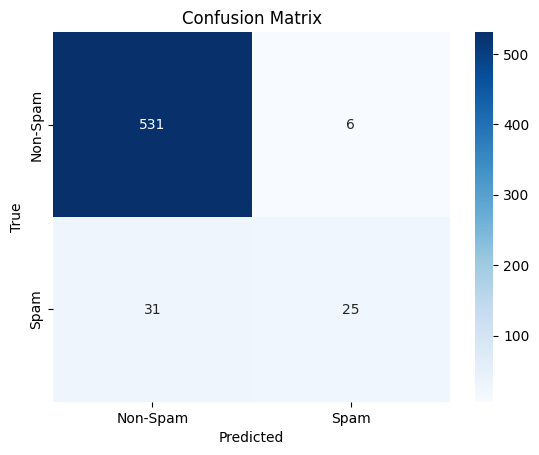

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Precision-Recall AUC: 0.6305516462276882


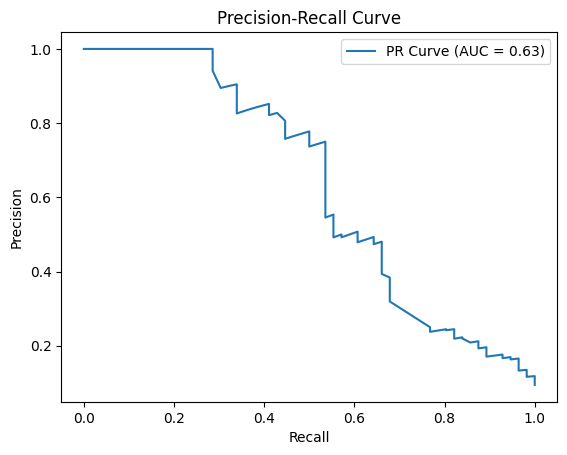

In [61]:
from sklearn.metrics import precision_recall_curve, auc

# Get precision-recall data
precision, recall, thresholds = precision_recall_curve(encoded_testing_labels, model.decision_function(X_test))

# Calculate area under the curve
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

# Plot the curve
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


Has a high accuracy of detecting non-spam urls. However its recall for spam-detection and F1 score is not great.